In [1]:
# PyTorch
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import  DataLoader
torch.manual_seed(0)

# Torchvision
import torchvision
import torchvision.datasets as datasets

# Other
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
from sklearn.manifold import TSNE

from typing import *
from tqdm import tqdm
import seaborn as sns

device = 'cuda:7' if torch.cuda.is_available() else 'cpu'

# -------------------- Variables ------------------------

# Join training and test set as a whole
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

dataset = torch.utils.data.ConcatDataset([mnist_trainset, mnist_testset])

dataloader = DataLoader(dataset = dataset, batch_size = 512, shuffle = True)
dataloader_1 = DataLoader(dataset = dataset, batch_size = 1, shuffle = True)

# Transform to convert tensor to image
img_transform = torchvision.transforms.ToPILImage()

In [14]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, in_channels: int, latent_dims: int, device: str, kernel_type: str, num_classes: int, hidden_dims: List = None,
                    reconstruction_weight: float = 1.0, mmd_weight: float = 1.0):
        super(VariationalAutoencoder, self).__init__()

        self.reconstruction_weight = reconstruction_weight
        self.mmd_weight = mmd_weight
        
        self.latent_dims = latent_dims
        self.kernel = kernel_type
        
        self.device = device
        self.num_classes = num_classes

        self.internal_img_size = (28 - len(hidden_dims) * 4)

        # Dictionary that stores the mean vector for each class in the latent space
        self.mean_latents = {}

        for clas in range(self.num_classes):

            # Initially, all classes have the same mean vector, but this will be updated
            self.mean_latents[clas] = torch.tensor([0] * self.latent_dims)


        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        modules = []

        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(

                    # Convolution
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size = 5, stride= 1),

                    # Batch Normalization
                    nn.BatchNorm2d(h_dim),

                    # PReLU with learnable parameters
                    nn.PReLU(num_parameters=h_dim, init=0.25, device=device)
                    )
            )
            in_channels = h_dim

        # Encoder
        self.encoder = nn.Sequential(*modules)
        
        # Linear layer for mu and sigma
        self.mu = nn.Linear(in_features = self.internal_img_size ** 2, out_features = latent_dims)
        self.sigma = nn.Linear(in_features = self.internal_img_size ** 2, out_features = latent_dims)

        # Normal distribution to sample gaussian noise
        self.N = torch.distributions.Normal(0, 1)

        # Allow sampling on the GPU
        self.N.loc = self.N.loc.to(self.device) 
        self.N.scale = self.N.scale.to(self.device)

        # Transform from latent space to original space
        self.latent2original = nn.Linear(in_features = latent_dims, out_features = self.internal_img_size **2)

        # Build Decoder
        modules = []

        for i in range(len(hidden_dims) - 1, -1, -1):
            modules.append(
                nn.Sequential(

                    # Deconvolution to reconstruct input
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i - 1],
                                       kernel_size=5,
                                       stride = 1),
                            
                    # Batch Normalization
                    nn.BatchNorm2d(hidden_dims[i - 1]),

                    # PReLU with learnable parameters
                    nn.PReLU(num_parameters=hidden_dims[i - 1], init=0.25, device=device)
                )
            )
        
        # Decoder
        self.decoder = nn.Sequential(*modules)
        

    def encode(self, x):

        #print("Input:",x.shape)
        x = self.encoder(x)
        #print("Encoder:",x.shape)
        x = torch.flatten(x, start_dim=1)
        #print("Flatten:",x.shape)

        mu =  self.mu(x)
        sigma = torch.exp(self.sigma(x))
        z = mu + sigma*self.N.sample(mu.shape)

        return [z, mu, sigma]

    def decode(self, x):
        #print("z input:",x.shape)
        x = self.latent2original(x)
        #print("latent2original:",x.shape)
        x = x.view((-1,1,self.internal_img_size ,self.internal_img_size))
        #print("View",x.shape)
        x = self.decoder(x)
        #print("Decoder",x.shape)
        return x

    def forward(self, x):

        # Encode
        latents, mu, sigma = self.encode(x)

        # Decode
        reconstruction = self.decode(latents)

        return [x, reconstruction, latents, mu, sigma]
    
    def compute_loss(self, inputs, reconstructions, latents, mu, sigma):

        # Reconstruction Loss
        recons_loss = F.mse_loss(inputs, reconstructions)

        # Maximum Mean Discrepancy
        mmd_loss = self.compute_mmd(latents)

        # Total Loss = Reconstruction Loss + MMD Loss (also, add weights)
        return self.reconstruction_weight * recons_loss , self.mmd_weight * mmd_loss

    def gaussian_kernel(self, x, y):

        """
        Computes gaussian kernel.

        Args:
            x (Tensor)
            y (Tensor)
        """
        x_size = x.shape[0]
        y_size = y.shape[0]
        dim = x.shape[1]

        tiled_x = x.view(x_size,1,dim).repeat(1, y_size,1)
        tiled_y = y.view(1,y_size,dim).repeat(x_size, 1,1)

        return torch.exp(-torch.mean((tiled_x - tiled_y)**2,dim=2)/dim*1.0)

    def inv_mult_quad_kernel(self, x: Tensor, y: Tensor, eps: float = 1e-7) -> Tensor:
        """
        Computes the Inverse Multi-Quadratics Kernel between x1 and x2,
        given by:

            k(x, y) = 1 / sqrt(|| x - y ||^2) + c
        
        Args:
            x (Tensor)
            y (Tensor)
            eps (float): Smoothing parameter, usually low
        """
        C = 2 * y.size(-1)
        kernel = C / (eps + C + (x - y).pow(2).sum(dim = -1))

        # Exclude diagonal elements
        result = kernel.sum() - kernel.diag().sum()

        return result

    def compute_kernel(self, x: Tensor, y: Tensor) -> Tensor:
        
        if self.kernel == 'gaussian':
            return self.gaussian_kernel(x, y)
        
        if self.kernel == 'imq':
            return self.inv_mult_quad_kernel(x, y)

    def compute_mmd(self, latents):
        """
        Computes Maximum Mean Discrepancy, used as regularization in the loss function.

        A rough intuition of MMD, is that if two distributions are identical, then the average “similarity” between samples
        from each distribution, should be identical to the average “similarity” between mixed samples from both distributions.
        """

        # Sample from prior Gaussian distribution
        prior_latent = torch.randn_like(latents)

        # Compute kernel for prior (Gaussian) distribution
        prior_kernel = self.compute_kernel(prior_latent, prior_latent)

        # Compute kernel for latent (learned) distribution
        latents_kernel = self.compute_kernel(latents, latents)

        # Compute mixed kernel to get similarity between distributions
        prior_latents_kernel = self.compute_kernel(prior_latent, latents)

        # MMD
        return torch.mean(prior_kernel) + torch.mean(latents_kernel) - 2 * torch.mean(prior_latents_kernel)

    def sample(self, num_samples:int, device: str) -> Tensor:
        """
        Samples from the latent space and returns the correspondingimage space map.

        Args:
            num_samples (int): Number of samples
            device (str): Device to run the model
        
        Returns:
            (Tensor) : The sample
        """

        # Sample from gaussian distribution
        z = torch.randn(num_samples, self.latent_dims)
        z = z.to(device)

        # Run through decoder
        samples = self.decode(z)

        return samples

    def sample_from_class(self, label: int, num_samples: int, noise: float = 0.1):
        """
        Given the class, returns a number of sampled images for that class

        Args:
            label (int): The class
            num_samples (int): Number of samples
        """

        # In order to sample, we will add gaussian noise to the mean vector
        # of the class in the latent space, and then decode the result
        z = self.mean_latents[label].to(self.device) + noise * torch.randn(num_samples, self.latent_dims).to(self.device)
        z = z.to(self.device)

        return self.decode(z)
        
    def generate(self, x: Tensor) -> Tensor:
        """
        Given an input image x, returns the reconstructed image

        Args:
            x (Tensor): The image as a tensor
        
        Returns:
            (Tensor): The reconstructed image
        """

        _, reconstruction, _, _, _ = self.forward(x)
        
        return reconstruction[0]

    def update_latent_dict(self, dataloader):
        """
        Updates the mean vector of each class in the latent space, and stores it
        in the mean vector dictionary.

        Args:
            dataloader(DataLoader): The whole data used for training
        """
        temp_dict = {key:torch.tensor([]).to(self.device) for key in range(self.num_classes)}

        for batch_idx, (inputs, labels) in enumerate(tqdm(dataloader, desc = "Updating mean vectors...")):

            inputs, labels = inputs.to(self.device), labels.to(self.device)

            # Get latent representation
            latents, _, _ = self.encode(inputs)

            # Separate by class
            for label in torch.unique(labels):

                samples = latents[labels == label]

                temp_dict[label.item()] = torch.cat((temp_dict[label.item()], samples),dim = 0)


        # Compute mean 
        for label in range(self.num_classes):

            self.mean_latents[label] = torch.mean(temp_dict[label], dim = 0)

        
        return

def train_vae(vae, data, epochs=20):
    """
    Trains the VAE for a number of epochs

    Args:
        autoencoder(torch.nn.Module): The VAE
        data(torch.utils.data.DataLoader): The data
        epochs (int): The number of epochs
    """

    # Optimizer
    opt = torch.optim.AdamW(vae.parameters(),lr=1e-3)

    for epoch in range(epochs):

        print("Epoch",epoch+1)

        total_loss = 0

        for inputs, labels in data:

            # GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Reset gradient
            opt.zero_grad()

            # Forward pass
            inputs, reconstruction, latents, mu, sigma = vae(inputs)

            # Get loss
            rec_loss, mmd_loss = vae.compute_loss(inputs, reconstruction, latents, mu, sigma)

            total_loss += rec_loss.item() + mmd_loss.item()

            # Backpropagate and optimize
            rec_loss.backward(retain_graph = True)
            mmd_loss.backward(retain_graph = True)

            opt.step()


        print("Loss:",total_loss / len(data))

    return vae

def visualize_reconstructions(vae, dataloader, num_samples: int = 10):

    fig = plt.figure(figsize=(num_samples, num_samples))
    plot_idx = 1
    for inputs, labels in dataloader:

        inputs, labels = inputs.to(device), labels.to(device)

        rec = vae.generate(inputs) 
        
        original_img = img_transform(inputs [0])
        rec_img = img_transform(rec)
        
        fig.add_subplot(num_samples, 2, plot_idx)
        plt.axis('off')
        plt.imshow(original_img)

        fig.add_subplot(num_samples, 2, plot_idx + 1)
        plt.axis('off')
        plt.imshow(rec_img)
        
        plot_idx += 2

        if plot_idx - 1 == num_samples * 2:
            return


Train VAE

In [17]:
# Build VAE
vae = VariationalAutoencoder(in_channels = 1,latent_dims = 128, device = device, kernel_type='imq', num_classes = 10, hidden_dims=[1,1], reconstruction_weight=10.0, mmd_weight=5.0)
vae.to(device)

vae = train_vae(vae, dataloader, epochs=100)

Epoch 1
Loss: 1.5934796755331275
Epoch 2
Loss: 0.45803158539925176
Epoch 3
Loss: 0.18895748866735584
Epoch 4
Loss: 0.11496757922598916
Epoch 5
Loss: 0.08889821367542239
Epoch 6
Loss: 0.07586552779169849
Epoch 7
Loss: 0.06694641092071568
Epoch 8
Loss: 0.06231996939130073
Epoch 9
Loss: 0.05754128182782744
Epoch 10
Loss: 0.05478544274929666
Epoch 11
Loss: 0.05129600346197177
Epoch 12
Loss: 0.04807183828993435
Epoch 13
Loss: 0.04873680054162541
Epoch 14
Loss: 0.044635641776079676
Epoch 15
Loss: 0.042643550239557765
Epoch 16
Loss: 0.04149790143553358
Epoch 17
Loss: 0.04015716923958194
Epoch 18
Loss: 0.04004001682692201
Epoch 19
Loss: 0.038178913839107015
Epoch 20
Loss: 0.03732933462971318
Epoch 21
Loss: 0.036341337337546104
Epoch 22
Loss: 0.035317600561972085
Epoch 23
Loss: 0.03428656267967537
Epoch 24
Loss: 0.033266109625135896
Epoch 25
Loss: 0.03217233926819189
Epoch 26
Loss: 0.03183010593056679
Epoch 27
Loss: 0.0313282290840671
Epoch 28
Loss: 0.03028523462423443
Epoch 29
Loss: 0.02976588

Update the mean vector of each class in the latent space, this is done to allow sampling per class

In [18]:
vae.update_latent_dict(dataloader)

Updating mean vectors...: 100%|██████████| 137/137 [00:04<00:00, 27.43it/s]


Sample images from the latent space

If images are too blurry, try lowering the noise parameter

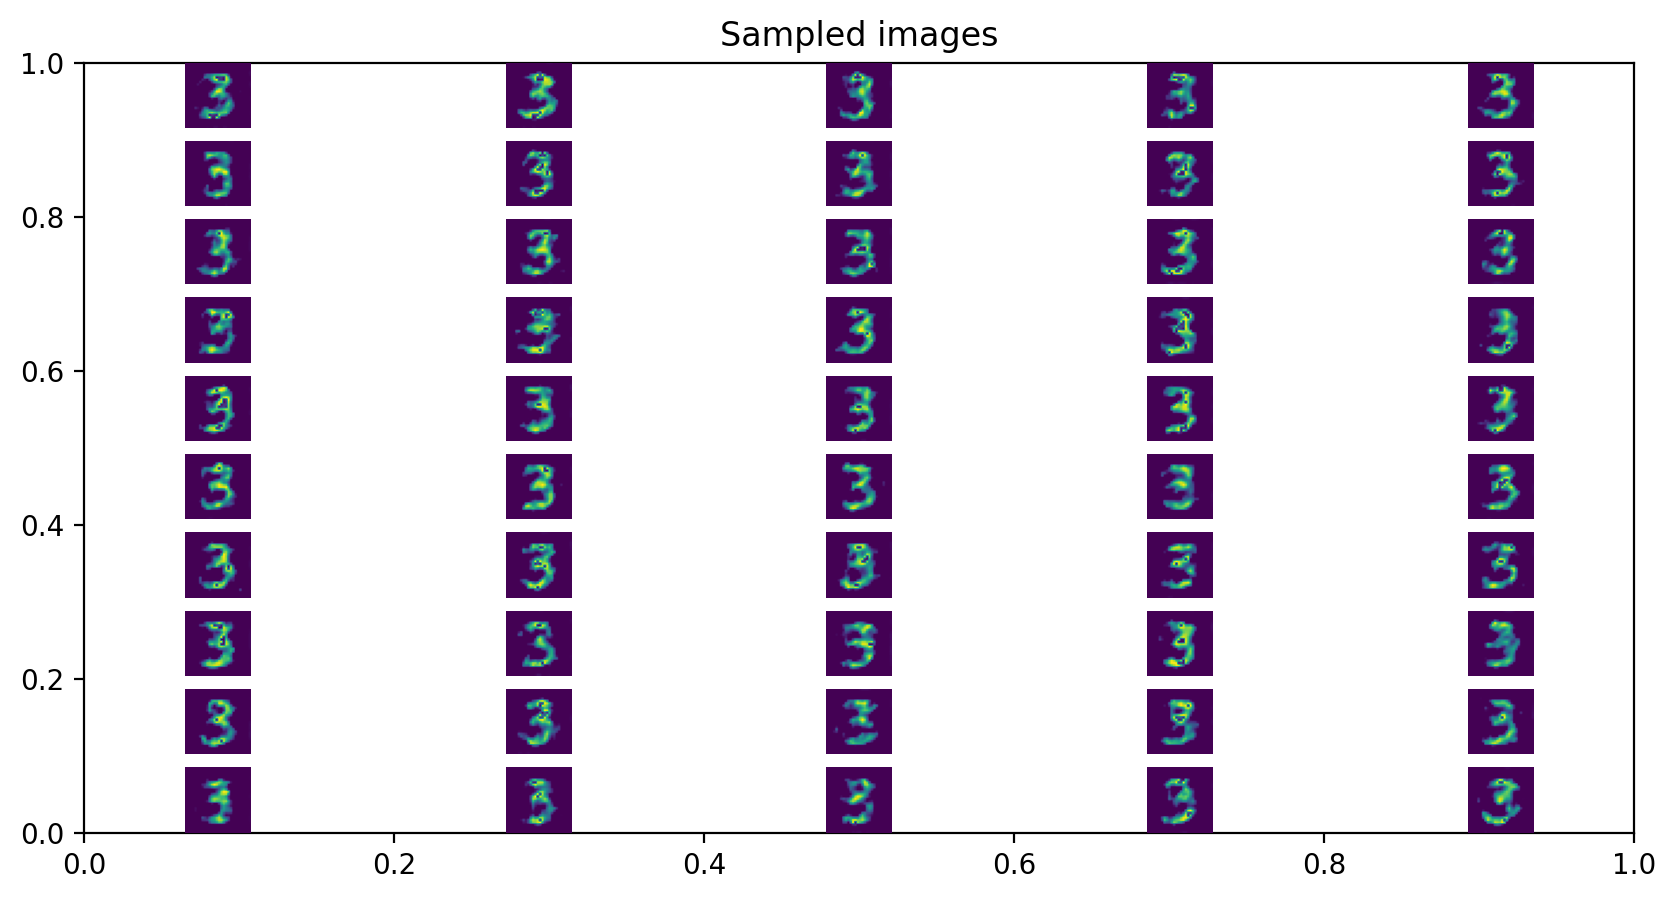

In [26]:
# Sample from class 3 a total of 50 samples with 0.5 gaussian noise from it's mean vector.
imgs = vae.sample_from_class(label = 3, num_samples = 50, noise = 0.5)

fig = plt.figure(figsize=(10, 5))
plt.title("Sampled images")
for idx,tensor in enumerate(imgs):

    img = img_transform(tensor)

    fig.add_subplot(10, 5, idx+1)
    plt.axis('off')
    plt.imshow(img)



Visualize original (left) and reconstructed images (right)

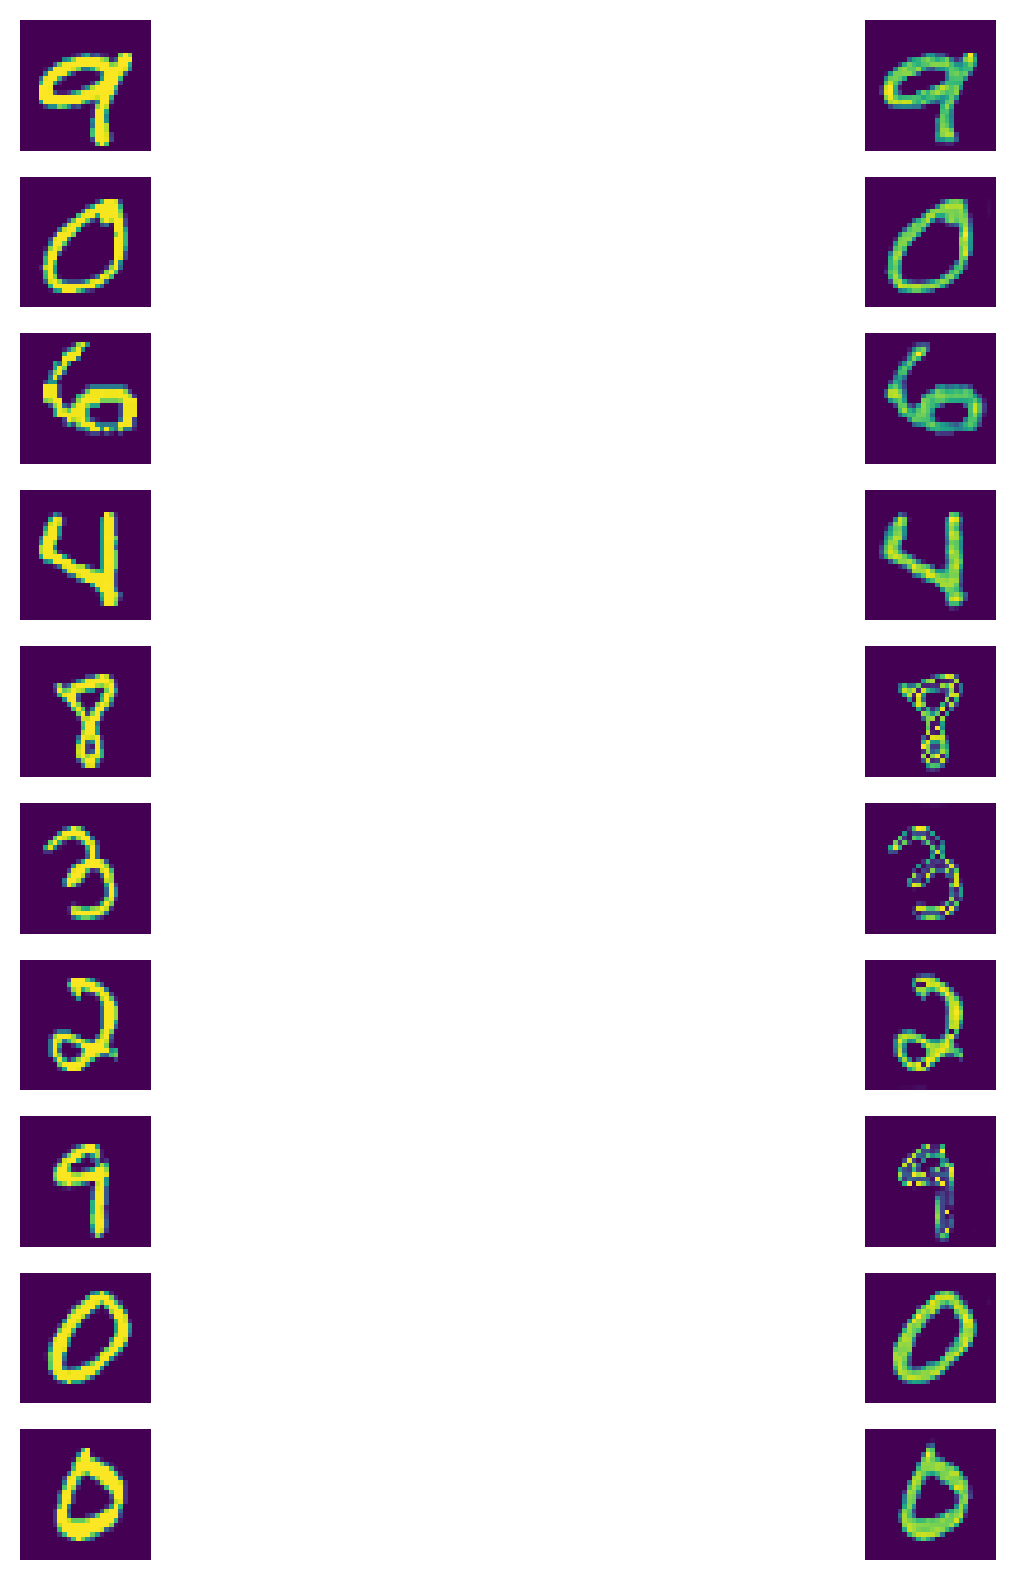

In [25]:
visualize_reconstructions(vae, dataloader_1, num_samples=10)

Extract latent space embedding for TSNE visualization

Extracting embeddings...: 5357it [00:04, 1269.24it/s]


Calculating TSNE...
Done


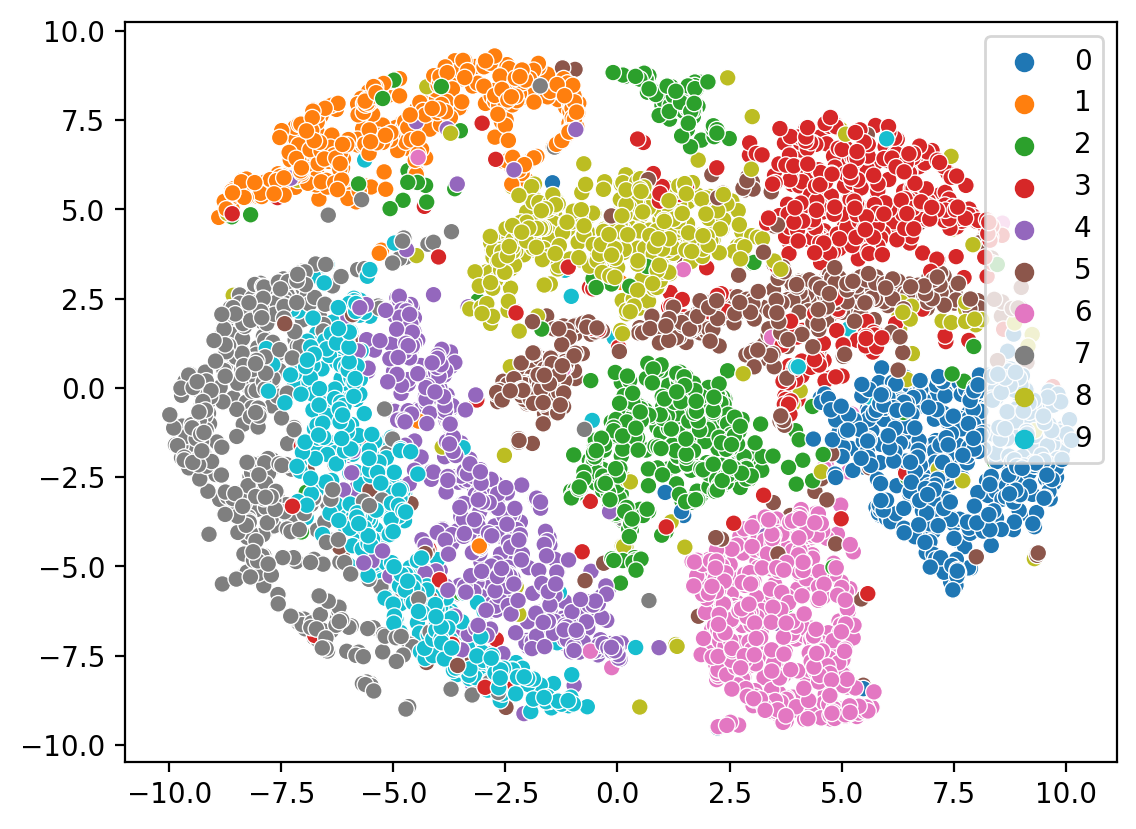

In [20]:
embedding_list = []
label_list = []


label_count = {
    0:0,
    1:0,
    2:0,
    3:0,
    4:0,
    5:0,
    6:0,
    7:0,
    8:0,
    9:0,
}

with torch.no_grad():

    for batch_idx, (inputs, labels) in tqdm(enumerate(dataloader_1), desc='Extracting embeddings...'):

        inputs, labels = inputs.to(device), labels.to(device)
        label = labels.item()

        # ResNet50 has 4 layers before the fully connected layers, how ever, we will only extract
        # the embedding from the second to the last layer, but we still have to feed the
        # inputs to the previous layers

        # Generate latent representation
        z, _, _ = vae.encode(inputs)
        embeddings = z

        if label_count[label] < 500:
            embedding_list.append(torch.flatten(embeddings.cpu().detach(), 1).numpy() [0])
            label_list.append( int(label))
        
        label_count[label] += 1

        # If we got 500 samples from each class, stop getting embeddings
        if not any([elem < 500 for elem in list(label_count.values())]):
            break


embedding_list = np.asarray([embedding_list]) [0]
tsne = TSNE(random_state = 0, n_components=2, verbose=0, perplexity=30, n_iter=300, init='random', learning_rate = 'auto')
print("Calculating TSNE...")
tsne_proj = tsne.fit_transform(embedding_list)
print("Done")

x_axis = tsne_proj[:,0]
y_axis = tsne_proj[:,1]

# Plot those points as a scatter plot and label them based on the pred labels
tsne_plot = sns.scatterplot(x=x_axis, y=y_axis, hue=np.array(label_list), legend='auto', palette=sns.color_palette("tab10"))
fig = tsne_plot.get_figure()
fig.show()


Plot the mean vectors in the latent space

Calculating TSNE...
Done


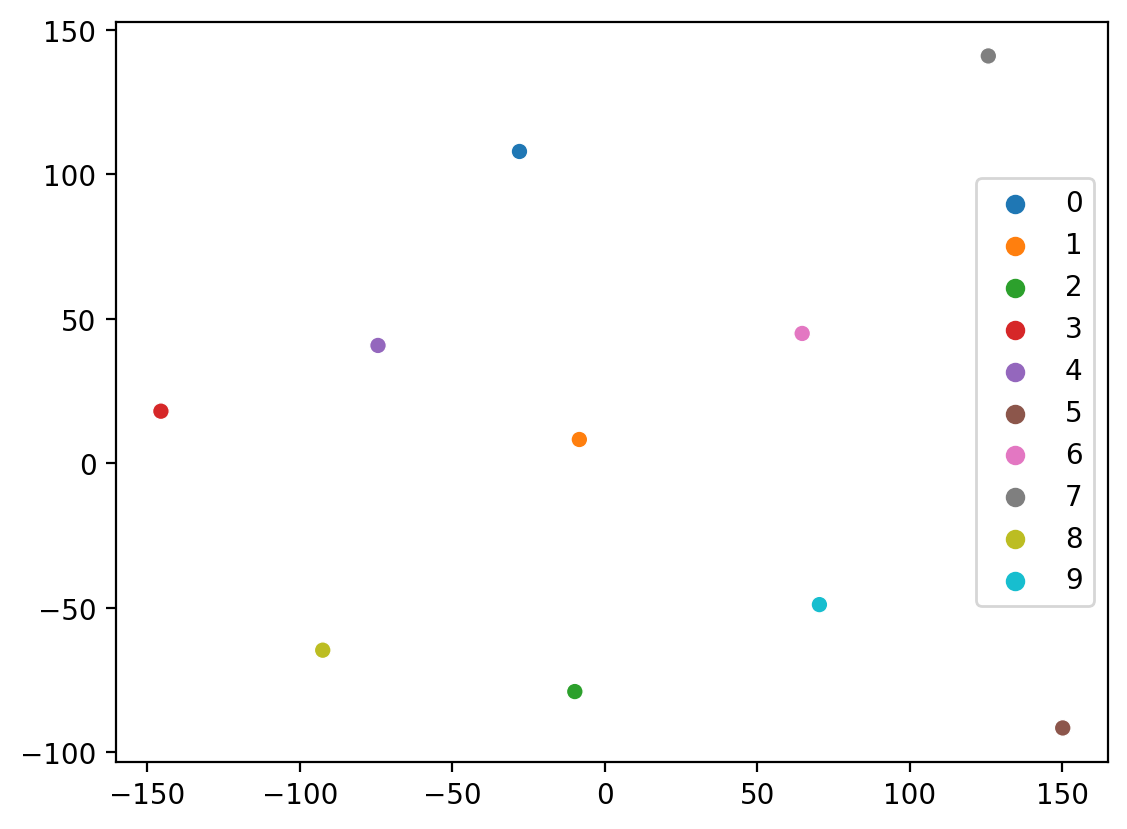

In [21]:
mean_vectors = []

for key in vae.mean_latents:
    mean_vectors.append(vae.mean_latents[key].cpu().detach().numpy())

tsne = TSNE(random_state = 0, n_components=2,verbose=0, perplexity=9, n_iter=300, init='random', learning_rate = 'auto')
print("Calculating TSNE...")
tsne_proj = tsne.fit_transform(np.asarray(mean_vectors))
print("Done")

x_axis = tsne_proj[:,0]
y_axis = tsne_proj[:,1]

# Plot those points as a scatter plot and label them based on the pred labels
tsne_plot = sns.scatterplot(x=x_axis, y=y_axis, hue=list(range(10)), legend='auto', palette=sns.color_palette("tab10"))
fig = tsne_plot.get_figure()
fig.show()

Save the model

In [22]:
model_state = {
            'model': vae.state_dict(),
        }

torch.save(model_state, './pretrained/' + 'InfoVAE_L128' + '.pth')